##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models. This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

## Setup

In [2]:
import matplotlib.pylab as plt

import tensorflow as tf

In [3]:
!pip3 install -q -U tf-hub-nightly
!pip3 install -q tfds-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer. Any [TensorFlow 2 compatible image classifier URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) from tfhub.dev will work here.

In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [5]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

 8192/61306 [===>..........................] - ETA: 0s

65536/61306 [================================] - 0s 0us/step


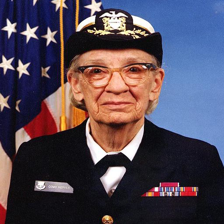

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

We have the predicted class ID,
Fetch the `ImageNet` labels, and decode the predictions

In [10]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

 8192/10484 [======================>.......] - ETA: 0s

16384/10484 [==============================================] - 0s 0us/step


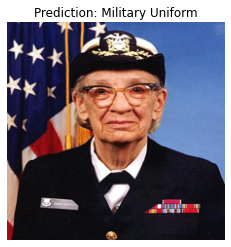

In [11]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Dataset

 For this example you will use the TensorFlow flowers dataset:

In [12]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

In [13]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [14]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [15]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [16]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'tick', 'lampshade', 'daisy', 'hen-of-the-woods', 'daisy',
       'harvester', 'fountain', 'daisy', 'daisy', 'sulphur butterfly',
       'greenhouse', 'daisy', 'daisy', 'cardoon', 'daisy', 'pot', 'pot',
       'pinwheel', "yellow lady's slipper", "jack-o'-lantern", 'vase',
       'bee', 'buckeye', 'pinwheel', 'daisy', 'fig', 'greenhouse', 'ant',
       'daisy', 'daisy', 'Arabian camel'], dtype='<U30')

Now check how these predictions line up with the images:

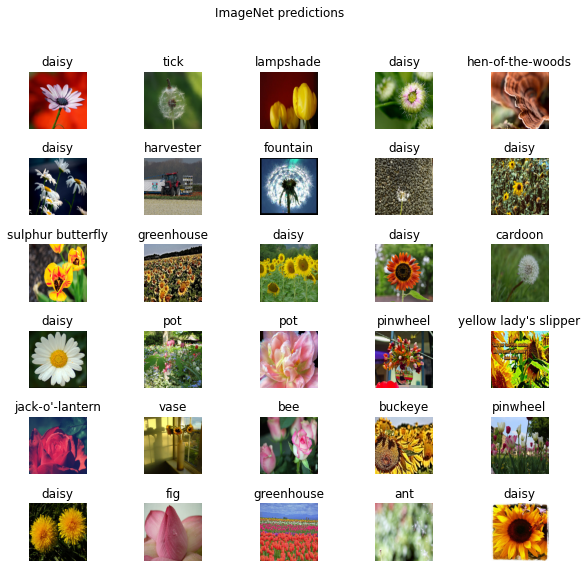

In [17]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

See the `LICENSE.txt` file for image attributions.

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [18]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

Create the feature extractor.

In [19]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

It returns a 1280-length vector for each image:

In [20]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [21]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [22]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
predictions = model(image_batch)

In [24]:
predictions.shape

TensorShape([32, 5])

### Train the model

Use compile to configure the training process:

In [25]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [26]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [27]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2


  1/115 [..............................] - ETA: 0s - loss: 1.7382 - acc: 0.2812

  2/115 [..............................] - ETA: 6s - loss: 1.7473 - acc: 0.3438

  3/115 [..............................] - ETA: 8s - loss: 1.8132 - acc: 0.3438

  4/115 [>.............................] - ETA: 9s - loss: 1.4511 - acc: 0.3750

  5/115 [>.............................] - ETA: 9s - loss: 1.4803 - acc: 0.3438

  6/115 [>.............................] - ETA: 9s - loss: 1.2207 - acc: 0.4375

  7/115 [>.............................] - ETA: 9s - loss: 1.4249 - acc: 0.3750

  8/115 [=>............................] - ETA: 9s - loss: 1.5991 - acc: 0.3438

  9/115 [=>............................] - ETA: 9s - loss: 1.4184 - acc: 0.3750

 10/115 [=>............................] - ETA: 9s - loss: 1.1642 - acc: 0.5625

 11/115 [=>............................] - ETA: 9s - loss: 1.1093 - acc: 0.6562

 12/115 [==>...........................] - ETA: 9s - loss: 1.0075 - acc: 0.5938

 13/115 [==>...........................] - ETA: 9s - loss: 1.2867 - acc: 0.5312

 14/115 [==>...........................] - ETA: 9s - loss: 1.2369 - acc: 0.4375

 15/115 [==>...........................] - ETA: 9s - loss: 1.1147 - acc: 0.5938

 16/115 [===>..........................] - ETA: 9s - loss: 0.8824 - acc: 0.5938

 17/115 [===>..........................] - ETA: 9s - loss: 0.8942 - acc: 0.7188

 18/115 [===>..........................] - ETA: 9s - loss: 0.8892 - acc: 0.6875

 19/115 [===>..........................] - ETA: 8s - loss: 0.8349 - acc: 0.6875

 20/115 [====>.........................] - ETA: 8s - loss: 0.8847 - acc: 0.6875

 21/115 [====>.........................] - ETA: 8s - loss: 1.0335 - acc: 0.5625

 22/115 [====>.........................] - ETA: 8s - loss: 0.7279 - acc: 0.8125

 23/115 [=====>........................] - ETA: 8s - loss: 1.0060 - acc: 0.6562

 24/115 [=====>........................] - ETA: 8s - loss: 0.9134 - acc: 0.6562

 25/115 [=====>........................] - ETA: 8s - loss: 0.7269 - acc: 0.7188

 26/115 [=====>........................] - ETA: 8s - loss: 0.6465 - acc: 0.8125

 27/115 [======>.......................] - ETA: 8s - loss: 0.8434 - acc: 0.7188

 28/115 [======>.......................] - ETA: 8s - loss: 0.7573 - acc: 0.7500

 29/115 [======>.......................] - ETA: 7s - loss: 0.7882 - acc: 0.6562

 30/115 [======>.......................] - ETA: 7s - loss: 0.6666 - acc: 0.7812

 31/115 [=======>......................] - ETA: 7s - loss: 0.7078 - acc: 0.8125

 32/115 [=======>......................] - ETA: 7s - loss: 0.6587 - acc: 0.7812

 33/115 [=======>......................] - ETA: 7s - loss: 0.6842 - acc: 0.7500

 34/115 [=======>......................] - ETA: 7s - loss: 0.7481 - acc: 0.6875

 35/115 [========>.....................] - ETA: 7s - loss: 0.4690 - acc: 0.8438

 36/115 [========>.....................] - ETA: 7s - loss: 0.5252 - acc: 0.7812

 37/115 [========>.....................] - ETA: 7s - loss: 0.5026 - acc: 0.8750

 38/115 [========>.....................] - ETA: 7s - loss: 0.7464 - acc: 0.8125

 39/115 [=========>....................] - ETA: 7s - loss: 0.4284 - acc: 0.9062

 40/115 [=========>....................] - ETA: 7s - loss: 0.4707 - acc: 0.9062

 41/115 [=========>....................] - ETA: 6s - loss: 0.6637 - acc: 0.7812

 42/115 [=========>....................] - ETA: 6s - loss: 0.5129 - acc: 0.8750

 43/115 [==========>...................] - ETA: 6s - loss: 0.8039 - acc: 0.6875

 44/115 [==========>...................] - ETA: 6s - loss: 0.5762 - acc: 0.7500

 45/115 [==========>...................] - ETA: 6s - loss: 0.8305 - acc: 0.7188

 46/115 [===========>..................] - ETA: 6s - loss: 0.4234 - acc: 0.8750

 47/115 [===========>..................] - ETA: 6s - loss: 0.7054 - acc: 0.7500

 48/115 [===========>..................] - ETA: 6s - loss: 0.6248 - acc: 0.7812

 49/115 [===========>..................] - ETA: 6s - loss: 0.4747 - acc: 0.8750

 50/115 [============>.................] - ETA: 6s - loss: 0.5796 - acc: 0.8125

 51/115 [============>.................] - ETA: 6s - loss: 0.6962 - acc: 0.7812

 52/115 [============>.................] - ETA: 6s - loss: 0.4206 - acc: 0.8750

 53/115 [============>.................] - ETA: 5s - loss: 0.4386 - acc: 0.9062

 54/115 [=============>................] - ETA: 5s - loss: 0.4227 - acc: 0.8438

 55/115 [=============>................] - ETA: 5s - loss: 0.4925 - acc: 0.8750

 56/115 [=============>................] - ETA: 5s - loss: 0.3804 - acc: 0.9545

 58/115 [==============>...............] - ETA: 5s - loss: 0.3626 - acc: 0.9375

 59/115 [==============>...............] - ETA: 5s - loss: 0.4027 - acc: 0.9062

 60/115 [==============>...............] - ETA: 5s - loss: 0.5057 - acc: 0.8750

 61/115 [==============>...............] - ETA: 5s - loss: 0.4567 - acc: 0.8438

 62/115 [===============>..............] - ETA: 5s - loss: 0.4752 - acc: 0.8438

 63/115 [===============>..............] - ETA: 5s - loss: 0.3004 - acc: 0.9375

 64/115 [===============>..............] - ETA: 4s - loss: 0.4840 - acc: 0.8125

 65/115 [===============>..............] - ETA: 4s - loss: 0.5325 - acc: 0.8750

 66/115 [================>.............] - ETA: 4s - loss: 0.5196 - acc: 0.8125

 67/115 [================>.............] - ETA: 4s - loss: 0.3565 - acc: 0.9375

 68/115 [================>.............] - ETA: 4s - loss: 0.5588 - acc: 0.8125

 69/115 [=================>............] - ETA: 4s - loss: 0.4800 - acc: 0.8125

 70/115 [=================>............] - ETA: 4s - loss: 0.3821 - acc: 0.8750

 71/115 [=================>............] - ETA: 4s - loss: 0.4706 - acc: 0.8125

 72/115 [=================>............] - ETA: 4s - loss: 0.5689 - acc: 0.8438

 73/115 [==================>...........] - ETA: 4s - loss: 0.4605 - acc: 0.8750

 74/115 [==================>...........] - ETA: 3s - loss: 0.5324 - acc: 0.8125

 75/115 [==================>...........] - ETA: 3s - loss: 0.4193 - acc: 0.8750

 76/115 [==================>...........] - ETA: 3s - loss: 0.5335 - acc: 0.8125

 77/115 [===================>..........] - ETA: 3s - loss: 0.3854 - acc: 0.8438

 78/115 [===================>..........] - ETA: 3s - loss: 0.3885 - acc: 0.8750

 79/115 [===================>..........] - ETA: 3s - loss: 0.4735 - acc: 0.8125

 80/115 [===================>..........] - ETA: 3s - loss: 0.5941 - acc: 0.8438

 81/115 [====================>.........] - ETA: 3s - loss: 0.3835 - acc: 0.8750

 82/115 [====================>.........] - ETA: 3s - loss: 0.3465 - acc: 0.9062

 83/115 [====================>.........] - ETA: 3s - loss: 0.3619 - acc: 0.8438

 84/115 [====================>.........] - ETA: 2s - loss: 0.5714 - acc: 0.7500

 85/115 [=====================>........] - ETA: 2s - loss: 0.4050 - acc: 0.8750

 86/115 [=====================>........] - ETA: 2s - loss: 0.4339 - acc: 0.9062

 87/115 [=====================>........] - ETA: 2s - loss: 0.5320 - acc: 0.8438

 88/115 [=====================>........] - ETA: 2s - loss: 0.4166 - acc: 0.8438

 89/115 [======================>.......] - ETA: 2s - loss: 0.3776 - acc: 0.8438

 90/115 [======================>.......] - ETA: 2s - loss: 0.2115 - acc: 0.9688

 91/115 [======================>.......] - ETA: 2s - loss: 0.2342 - acc: 0.9688

 92/115 [=======================>......] - ETA: 2s - loss: 0.4675 - acc: 0.8438

 93/115 [=======================>......] - ETA: 2s - loss: 0.3268 - acc: 0.9062

 94/115 [=======================>......] - ETA: 2s - loss: 0.5878 - acc: 0.7812

 95/115 [=======================>......] - ETA: 1s - loss: 0.4637 - acc: 0.8438

 96/115 [========================>.....] - ETA: 1s - loss: 0.4051 - acc: 0.8750

 97/115 [========================>.....] - ETA: 1s - loss: 0.4212 - acc: 0.8750

 98/115 [========================>.....] - ETA: 1s - loss: 0.4451 - acc: 0.8750

 99/115 [========================>.....] - ETA: 1s - loss: 0.6402 - acc: 0.7500

100/115 [=========================>....] - ETA: 1s - loss: 0.3648 - acc: 0.9688

101/115 [=========================>....] - ETA: 1s - loss: 0.4017 - acc: 0.8438



102/115 [=========================>....] - ETA: 1s - loss: 0.3777 - acc: 0.8438

103/115 [=========================>....] - ETA: 1s - loss: 0.2574 - acc: 0.9062

104/115 [==========================>...] - ETA: 1s - loss: 0.5090 - acc: 0.7500

105/115 [==========================>...] - ETA: 0s - loss: 0.2461 - acc: 0.8750

106/115 [==========================>...] - ETA: 0s - loss: 0.4313 - acc: 0.8125

107/115 [==========================>...] - ETA: 0s - loss: 0.3810 - acc: 0.8438

108/115 [===========================>..] - ETA: 0s - loss: 0.3090 - acc: 0.9062

109/115 [===========================>..] - ETA: 0s - loss: 0.7396 - acc: 0.6250

110/115 [===========================>..] - ETA: 0s - loss: 0.5212 - acc: 0.8438

111/115 [===========================>..] - ETA: 0s - loss: 0.4376 - acc: 0.8750

112/115 [============================>.] - ETA: 0s - loss: 0.2824 - acc: 0.9688

113/115 [============================>.] - ETA: 0s - loss: 0.5109 - acc: 0.8125

114/115 [============================>.] - ETA: 0s - loss: 0.4182 - acc: 0.8125

115/115 [==============================] - ETA: 0s - loss: 0.3839 - acc: 0.8750

115/115 [==============================] - 11s 96ms/step - loss: 0.3839 - acc: 0.8750


Epoch 2/2


  1/115 [..............................] - ETA: 0s - loss: 0.4305 - acc: 0.9062

  2/115 [..............................] - ETA: 4s - loss: 0.6132 - acc: 0.8125

  3/115 [..............................] - ETA: 6s - loss: 0.3464 - acc: 0.8750

  4/115 [>.............................] - ETA: 7s - loss: 0.2752 - acc: 0.9375

  5/115 [>.............................] - ETA: 7s - loss: 0.4918 - acc: 0.8125

  6/115 [>.............................] - ETA: 8s - loss: 0.2708 - acc: 0.8750

  7/115 [>.............................] - ETA: 8s - loss: 0.3240 - acc: 0.9375

  8/115 [=>............................] - ETA: 8s - loss: 0.3938 - acc: 0.7500

  9/115 [=>............................] - ETA: 8s - loss: 0.3245 - acc: 0.8750

 10/115 [=>............................] - ETA: 8s - loss: 0.4175 - acc: 0.9375

 11/115 [=>............................] - ETA: 8s - loss: 0.4917 - acc: 0.9062

 12/115 [==>...........................] - ETA: 8s - loss: 0.3929 - acc: 0.8750

 13/115 [==>...........................] - ETA: 8s - loss: 0.4834 - acc: 0.8125

 14/115 [==>...........................] - ETA: 8s - loss: 0.4056 - acc: 0.8438

 15/115 [==>...........................] - ETA: 8s - loss: 0.3156 - acc: 0.8750

 16/115 [===>..........................] - ETA: 8s - loss: 0.2815 - acc: 0.9375

 17/115 [===>..........................] - ETA: 8s - loss: 0.2904 - acc: 0.9688

 18/115 [===>..........................] - ETA: 8s - loss: 0.4287 - acc: 0.8438

 19/115 [===>..........................] - ETA: 8s - loss: 0.3848 - acc: 0.7812

 20/115 [====>.........................] - ETA: 8s - loss: 0.2639 - acc: 0.8750

 21/115 [====>.........................] - ETA: 8s - loss: 0.2644 - acc: 0.9375

 22/115 [====>.........................] - ETA: 8s - loss: 0.2647 - acc: 0.9062

 23/115 [=====>........................] - ETA: 8s - loss: 0.4320 - acc: 0.8125

 24/115 [=====>........................] - ETA: 8s - loss: 0.2115 - acc: 0.9375

 25/115 [=====>........................] - ETA: 8s - loss: 0.3374 - acc: 0.8438

 26/115 [=====>........................] - ETA: 8s - loss: 0.3985 - acc: 0.8125

 27/115 [======>.......................] - ETA: 7s - loss: 0.3362 - acc: 0.9375

 28/115 [======>.......................] - ETA: 7s - loss: 0.4542 - acc: 0.8438

 29/115 [======>.......................] - ETA: 7s - loss: 0.3207 - acc: 0.8750

 30/115 [======>.......................] - ETA: 7s - loss: 0.3450 - acc: 0.8750

 31/115 [=======>......................] - ETA: 7s - loss: 0.2412 - acc: 0.9375

 32/115 [=======>......................] - ETA: 7s - loss: 0.4751 - acc: 0.8125

 33/115 [=======>......................] - ETA: 7s - loss: 0.4224 - acc: 0.8438

 34/115 [=======>......................] - ETA: 7s - loss: 0.2015 - acc: 1.0000

 35/115 [========>.....................] - ETA: 7s - loss: 0.3326 - acc: 0.9375

 36/115 [========>.....................] - ETA: 7s - loss: 0.2565 - acc: 0.9062

 37/115 [========>.....................] - ETA: 7s - loss: 0.3421 - acc: 0.8750

 38/115 [========>.....................] - ETA: 7s - loss: 0.2783 - acc: 0.9062

 39/115 [=========>....................] - ETA: 7s - loss: 0.2391 - acc: 0.8750

 40/115 [=========>....................] - ETA: 6s - loss: 0.1941 - acc: 0.9062

 41/115 [=========>....................] - ETA: 6s - loss: 0.3280 - acc: 0.8750

 42/115 [=========>....................] - ETA: 6s - loss: 0.4043 - acc: 0.8125

 43/115 [==========>...................] - ETA: 6s - loss: 0.2819 - acc: 0.9375

 44/115 [==========>...................] - ETA: 6s - loss: 0.5026 - acc: 0.8750

 45/115 [==========>...................] - ETA: 6s - loss: 0.2736 - acc: 0.9375

 46/115 [===========>..................] - ETA: 6s - loss: 0.2077 - acc: 0.9375

 47/115 [===========>..................] - ETA: 6s - loss: 0.2724 - acc: 0.9091

 48/115 [===========>..................] - ETA: 6s - loss: 0.3399 - acc: 0.9062

 49/115 [===========>..................] - ETA: 6s - loss: 0.2502 - acc: 0.9375

 50/115 [============>.................] - ETA: 6s - loss: 0.4551 - acc: 0.8750

 51/115 [============>.................] - ETA: 5s - loss: 0.4345 - acc: 0.8438

 52/115 [============>.................] - ETA: 5s - loss: 0.2724 - acc: 0.8750

 53/115 [============>.................] - ETA: 5s - loss: 0.2863 - acc: 0.9375

 54/115 [=============>................] - ETA: 5s - loss: 0.1543 - acc: 1.0000

 55/115 [=============>................] - ETA: 5s - loss: 0.4023 - acc: 0.8438

 56/115 [=============>................] - ETA: 5s - loss: 0.3660 - acc: 0.8125

 57/115 [=============>................] - ETA: 5s - loss: 0.3271 - acc: 0.9375

 58/115 [==============>...............] - ETA: 5s - loss: 0.3216 - acc: 0.9062

 59/115 [==============>...............] - ETA: 5s - loss: 0.4111 - acc: 0.8438

 60/115 [==============>...............] - ETA: 5s - loss: 0.3144 - acc: 0.8750

 61/115 [==============>...............] - ETA: 5s - loss: 0.2410 - acc: 0.9375

 62/115 [===============>..............] - ETA: 4s - loss: 0.2273 - acc: 0.9375

 63/115 [===============>..............] - ETA: 4s - loss: 0.3659 - acc: 0.8438

 64/115 [===============>..............] - ETA: 4s - loss: 0.5066 - acc: 0.8750

 65/115 [===============>..............] - ETA: 4s - loss: 0.2742 - acc: 0.9062

 66/115 [================>.............] - ETA: 4s - loss: 0.3190 - acc: 0.8750

 67/115 [================>.............] - ETA: 4s - loss: 0.5591 - acc: 0.8125

 68/115 [================>.............] - ETA: 4s - loss: 0.2972 - acc: 0.8750

 69/115 [=================>............] - ETA: 4s - loss: 0.2740 - acc: 0.9062

 70/115 [=================>............] - ETA: 4s - loss: 0.3546 - acc: 0.8438

 71/115 [=================>............] - ETA: 4s - loss: 0.2520 - acc: 0.9062

 72/115 [=================>............] - ETA: 4s - loss: 0.4017 - acc: 0.8750

 73/115 [==================>...........] - ETA: 3s - loss: 0.2336 - acc: 0.9062

 74/115 [==================>...........] - ETA: 3s - loss: 0.1880 - acc: 0.9375

 75/115 [==================>...........] - ETA: 3s - loss: 0.4513 - acc: 0.8125

 76/115 [==================>...........] - ETA: 3s - loss: 0.1842 - acc: 0.9375

 77/115 [===================>..........] - ETA: 3s - loss: 0.5177 - acc: 0.8750

 78/115 [===================>..........] - ETA: 3s - loss: 0.3692 - acc: 0.8750

 79/115 [===================>..........] - ETA: 3s - loss: 0.4193 - acc: 0.8125

 80/115 [===================>..........] - ETA: 3s - loss: 0.4565 - acc: 0.8438

 81/115 [====================>.........] - ETA: 3s - loss: 0.4620 - acc: 0.8750

 82/115 [====================>.........] - ETA: 3s - loss: 0.2745 - acc: 0.8750

 83/115 [====================>.........] - ETA: 3s - loss: 0.6386 - acc: 0.6562

 84/115 [====================>.........] - ETA: 2s - loss: 0.2365 - acc: 0.9688

 85/115 [=====================>........] - ETA: 2s - loss: 0.3902 - acc: 0.8750

 86/115 [=====================>........] - ETA: 2s - loss: 0.1217 - acc: 1.0000

 87/115 [=====================>........] - ETA: 2s - loss: 0.2482 - acc: 0.9062

 88/115 [=====================>........] - ETA: 2s - loss: 0.4156 - acc: 0.8750

 89/115 [======================>.......] - ETA: 2s - loss: 0.3144 - acc: 0.8750

 90/115 [======================>.......] - ETA: 2s - loss: 0.1704 - acc: 0.9375

 91/115 [======================>.......] - ETA: 2s - loss: 0.1803 - acc: 0.9375

 92/115 [=======================>......] - ETA: 2s - loss: 0.3897 - acc: 0.8438

 93/115 [=======================>......] - ETA: 2s - loss: 0.2037 - acc: 0.9375

 94/115 [=======================>......] - ETA: 1s - loss: 0.1821 - acc: 0.9688

 95/115 [=======================>......] - ETA: 1s - loss: 0.4149 - acc: 0.8438

 96/115 [========================>.....] - ETA: 1s - loss: 0.3222 - acc: 0.9062

 97/115 [========================>.....] - ETA: 1s - loss: 0.2474 - acc: 0.9375

 98/115 [========================>.....] - ETA: 1s - loss: 0.3451 - acc: 0.9062

 99/115 [========================>.....] - ETA: 1s - loss: 0.1696 - acc: 0.9688

100/115 [=========================>....] - ETA: 1s - loss: 0.1736 - acc: 0.9375

101/115 [=========================>....] - ETA: 1s - loss: 0.2074 - acc: 0.9375

102/115 [=========================>....] - ETA: 1s - loss: 0.3172 - acc: 0.9062

103/115 [=========================>....] - ETA: 1s - loss: 0.4098 - acc: 0.9062

104/115 [==========================>...] - ETA: 1s - loss: 0.2086 - acc: 0.9062

105/115 [==========================>...] - ETA: 0s - loss: 0.3114 - acc: 0.9062

106/115 [==========================>...] - ETA: 0s - loss: 0.3946 - acc: 0.8438

107/115 [==========================>...] - ETA: 0s - loss: 0.1605 - acc: 0.9688

108/115 [===========================>..] - ETA: 0s - loss: 0.2856 - acc: 0.8750

109/115 [===========================>..] - ETA: 0s - loss: 0.3574 - acc: 0.9375

110/115 [===========================>..] - ETA: 0s - loss: 0.3141 - acc: 0.8750

111/115 [===========================>..] - ETA: 0s - loss: 0.2859 - acc: 0.9062

112/115 [============================>.] - ETA: 0s - loss: 0.3256 - acc: 0.9062

113/115 [============================>.] - ETA: 0s - loss: 0.3509 - acc: 0.9375

114/115 [============================>.] - ETA: 0s - loss: 0.2310 - acc: 0.9375

115/115 [==============================] - ETA: 0s - loss: 0.1540 - acc: 0.9688

115/115 [==============================] - 11s 95ms/step - loss: 0.1540 - acc: 0.9688


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

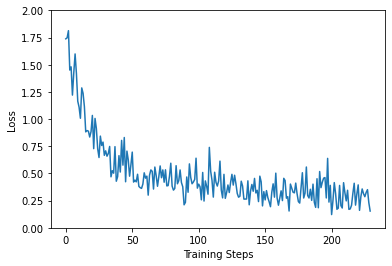

In [28]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

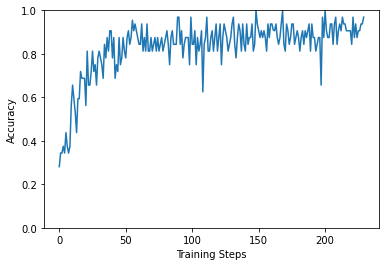

In [29]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [30]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [31]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [32]:
label_id = np.argmax(label_batch, axis=-1)

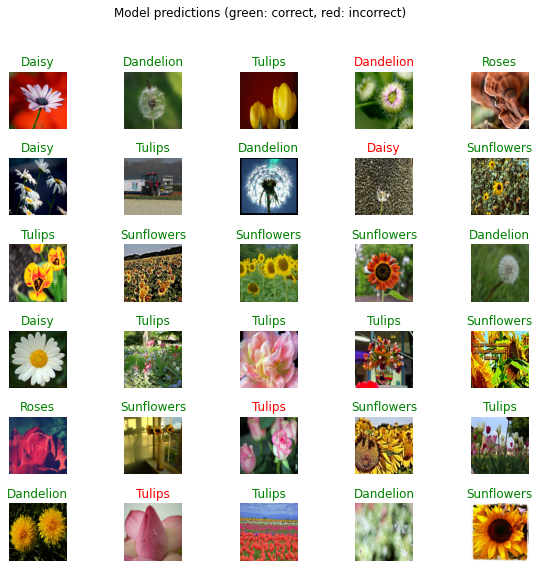

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a saved model:

In [34]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1591933992/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1591933992/assets


'/tmp/saved_models/1591933992'

Now confirm that we can reload it, and it still gives the same results:

In [35]:
reloaded = tf.keras.models.load_model(export_path)

In [36]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [37]:
abs(reloaded_result_batch - result_batch).max()

0.0

This saved model can be loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).
